In [1]:
import findspark
findspark.init()

In [2]:

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import isnan, isnull, when, count, col,expr
from pyspark.sql.types import StructField, StructType, StringType, LongType,IntegerType,StringType
from pyspark.sql import functions as fn
from pyspark.ml import feature,regression,Pipeline
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [3]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [4]:
df = spark.read.format("csv").load("hospital_readmission_cleaned.csv",header=True)

In [5]:
df.toPandas().head(2)

,race,diag_1,diag_2,diag_3,admission_type_name,dischage_disposition_name,admission_source_name,gender,age,time_in_hospital,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,Caucasian,250.83,276,276,Emergency,Not Mapped,Physician Referral,Female,[0-10),1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,276,250.01,255,Emergency,Discharged to home,Emergency Room,Female,[10-20),3,...,No,No,No,No,No,Up,No,Ch,Yes,1


In [10]:
df.describe()

DataFrame[summary: string, race: string, diag_1: string, diag_2: string, diag_3: string, admission_type_name: string, dischage_disposition_name: string, admission_source_name: string, gender: string, age: string, time_in_hospital: string, num_lab_procedures: string, num_procedures: string, num_medications: string, number_outpatient: string, number_emergency: string, number_inpatient: string, number_diagnoses: string, max_glu_serum: string, A1Cresult: string, metformin: string, repaglinide: string, nateglinide: string, chlorpropamide: string, glimepiride: string, glipizide: string, glyburide: string, pioglitazone: string, rosiglitazone: string, acarbose: string, miglitol: string, insulin: string, glyburide-metformin: string, change: string, diabetesMed: string, readmitted: string]

## Exploratory Data Analysis

### How the patient's are distributed w.r.t race?

In [ ]:
raceDF = df.groupby(['race','readmitted']).count().toPandas().sort_values(by='count',ascending=False)
# Create bars
plt.figure(figsize=(12,6))
sns.barplot(y='count',x = 'race', data = raceDF, hue ='readmitted')
# Adding Title
plt.title('Distribution of patients by race')
# Show graphic
plt.show()

The above plot gives the information about the number of cases grouped by race.About 77% of the total cases are from 'Caucasian' race followed by 'African American' with around 18% of total cases. Only 46% of total 'Caucasian' cases were readmitted and the rest 53.5% were not readmitted. Of all the 'African American' cases, 45.7% patients were readmitted to the hospital. Both the Caucasian and African American are the major races in the dataset, about 95% of the total data belongs to these two races. 2.32% of the total data belongs to 'Hispanic' followed by 'Others' with 1.47%. Asian with the least number of cases with only 0.62% total cases.

In [ ]:
raceDF

### What is the count of male and female patient's in the dataset and also among those how many have been readmitted again ?

In [ ]:
genderDF = df.groupby(['gender','readmitted']).count().toPandas().sort_values(by='count',ascending=False)
# Create bars
plt.figure(figsize=(12,6))
sns.barplot(y='count',x = 'gender', data = genderDF, hue ='readmitted')
# Adding Title
plt.title('Count of reviews by Gender')
# Show graphic
plt.show()

The above plot gives the information about the count of cases by gender and and whether they are admitted again or not. The dataset is balanced w.r.t. Gender since we have around 53% Females nad 47% males. Among the female cases, around 47% cases were readmitted again on the other hand 45% of total male cases were readmitted again. 

In [ ]:
genderDF

### What age group of patient are most admitted in the hospital? 

In [ ]:
ageDF = df.groupby(['age','readmitted']).count().toPandas().sort_values(by='age')
ageDF1 = df.groupby(['age','gender']).count().toPandas().sort_values(by='age')
# Create bars
f,axes = plt.subplots(1,2,figsize=(16,6))
g=sns.barplot(y='count',x = 'age', data = ageDF, hue ='readmitted',ax=axes[0])
t= sns.barplot(y='count',x = 'age', data = ageDF1, hue ='gender',ax=axes[1])
# Adding Title
plt.title('Distribution of age-group w.r.t readmission state and age')
# Show graphic
plt.show()

Given the above bar plot of age-group grouped w.r.t to readmission and gender, data is left-skewed with people within age group of 70-80 have the highest number of count in the dataset. The reason can be many and one of the reason can be since the average life span of human life in USA is approximately 78 according to CDC (link - https://www.cdc.gov/nchs/fastats/life-expectancy.htm). Number of female patient in comparison with male after 70 years of age is higher with great margin. People withing agegroup 60-70 are second most number of patient admitted to the hospital followed by age group 50-60 and 80-90.

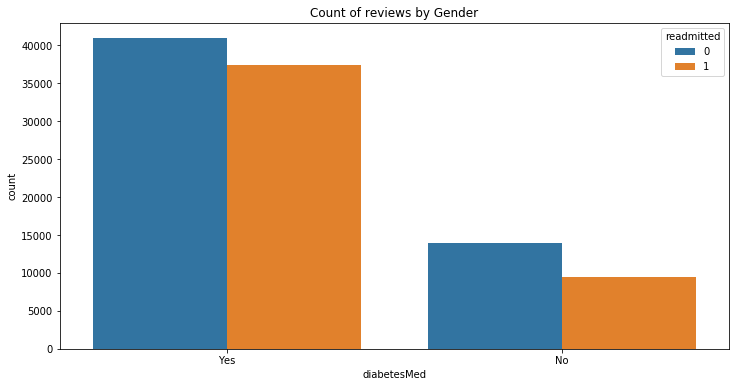

In [19]:
genderDF = df.groupby(['diabetesMed','readmitted']).count().toPandas().sort_values(by='count',ascending=False)
# Create bars
plt.figure(figsize=(12,6))
sns.barplot(y='count',x = 'diabetesMed', data = genderDF, hue ='readmitted')
# Adding Title
plt.title('Count of reviews by Gender')
# Show graphic
plt.show()

In [6]:
df.columns

['race',
 'diag_1',
 'diag_2',
 'diag_3',
 'admission_type_name',
 'dischage_disposition_name',
 'admission_source_name',
 'gender',
 'age',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'insulin',
 'glyburide-metformin',
 'change',
 'diabetesMed',
 'readmitted']